## Initial Guesses
This notebook generates some guesses for the $\varepsilon_{AB}$ values based on the approximation $g_{AB}(r)\approx e^{-\beta V(r)}$ using the scipy quad method for integration and scipy minimize_scalar with brackets to minimize the difference between desired and estimated $N_{AB}$ values.

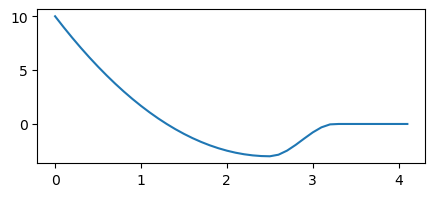

In [1]:
from scipy.integrate import quad
from scipy.optimize import minimize_scalar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

eps_1 = 10.
alpha = 1.3

def potential(r, eps_2, r_m):
    if r < r_m:
        return (eps_1+eps_2)*(1-r/r_m)**2 - eps_2
    elif r <= (alpha*r_m):
        r_M = alpha*r_m
        upper_brak = ((r_M-r)**2)*(r_M - 3*r_m + 2*r)
        lower_brak = (r_M - r_m)**3
        return -eps_2*(upper_brak/lower_brak)
    else: 
        return 0.
    
def g_ab_approx(r, eps_2, r_m):
    return 4*np.pi*(r**2)*np.exp(-potential(r, eps_2, r_m))

coords = np.arange(0., 4.2, 0.1)
vals = [potential(step, 3., 2.5) for step in coords]
plt.figure(figsize=[5,2])
plt.plot(coords, vals)
plt.show()

In [2]:
def scalar_func(eps_2, r_m):
    integral = quad(g_ab_approx, 0., 1.1*alpha*r_m, args=(eps_2, r_m))
    inte_val = integral[0]
    inte_abs_err = integral[1]
    
    if inte_abs_err/inte_val > 0.05:
        print(f"Warning, large error in eval with eps={eps_2} r_m={r_m}")
    
    return inte_val 

In [3]:
ff_df = pd.read_csv("testReferenceFF_df.csv", index_col=0)
protein_df = pd.read_csv("exampleProteinDF.csv", index_col=0)
para_df = pd.read_csv("defaultParaFile.csv", index_col=0)
volume = para_df[para_df.index=="volume [nm**3]"].values[0,0]
ff_df["inte_val"] = None
ff_df["r_m [nm]"] = None
ff_df

ProteinA ProteinB  Eps_AB      N_pairs  N_pair_std   ref_eps inte_val  \
0     UL83    UL100     0.0  1456.085727   38.020063 -2.160730     None   
1     UL83     UL25     0.0   556.922795   26.162309 -3.993441     None   
2     UL83     UL82     0.0  5769.888841   76.660734 -2.253403     None   
3     UL83     UL83     0.0  6673.783614   71.310307 -0.809791     None   
4     UL82    UL100     0.0  2196.767159   41.979289 -1.298799     None   
5     UL82     UL25     0.0  7453.576182   70.803004  0.431794     None   
6     UL82     UL82     0.0  3136.555000   49.413894 -3.106198     None   
7     UL25    UL100     0.0   285.985864   17.498620 -2.308524     None   
8     UL25     UL25     0.0  2486.715045   69.168324  0.557606     None   
9    UL100    UL100     0.0   389.326045   19.318085 -0.623422     None   

  r_m [nm]  
0     None  
1     None  
2     None  
3     None  
4     None  
5     None  
6     None  
7     None  
8     None  
9     None

In [4]:
for i, row in ff_df.iterrows():
    
    pA = row["ProteinA"]
    pB = row["ProteinB"]

    p_info_rowA = protein_df[protein_df.name == pA]
    p_info_rowB = protein_df[protein_df.name == pB]

    r_m = ((p_info_rowA["r_m [A]"].iloc[0]) + (p_info_rowB["r_m [A]"].iloc[0]))/10.

    inte_val = row["N_pairs"]*volume
    inte_val /= p_info_rowA["count"].values*p_info_rowB["count"].values

    ff_df.loc[i,"inte_val"] = inte_val
    ff_df.loc[i,"r_m [nm]"] = r_m
    
ff_df

ProteinA ProteinB  Eps_AB      N_pairs  N_pair_std   ref_eps  \
0     UL83    UL100     0.0  1456.085727   38.020063 -2.160730   
1     UL83     UL25     0.0   556.922795   26.162309 -3.993441   
2     UL83     UL82     0.0  5769.888841   76.660734 -2.253403   
3     UL83     UL83     0.0  6673.783614   71.310307 -0.809791   
4     UL82    UL100     0.0  2196.767159   41.979289 -1.298799   
5     UL82     UL25     0.0  7453.576182   70.803004  0.431794   
6     UL82     UL82     0.0  3136.555000   49.413894 -3.106198   
7     UL25    UL100     0.0   285.985864   17.498620 -2.308524   
8     UL25     UL25     0.0  2486.715045   69.168324  0.557606   
9    UL100    UL100     0.0   389.326045   19.318085 -0.623422   

             inte_val  r_m [nm]  
0   943.0753633947207  5.888911  
1  351.80055604482544  6.777559  
2  1018.0192599737975  6.226334  
3  1141.5108136831739  6.137607  
4  1467.6554835854424  5.977639  
5   4856.762440259977  6.866287  
6   570.8501176927371  6.315062  
7   684.0654238936337  6.528864  
8   5801.244472099851  7.417511  
9   954.8264900343323  5.640216

In [5]:
ff_df["Eps_Guess"] = None
bounds = [-100., 5.]

for i, row in ff_df.iterrows():
    desired_val = row["inte_val"]
    tmp_r_m = row["r_m [nm]"]
    
    def tmp_func(eps):
        scalar = scalar_func(eps, tmp_r_m)
        val = (scalar - desired_val)**2
        return val
    
    result = minimize_scalar(tmp_func, bounds = [-100., 5.])
    result_val = result.x
    
    if result_val/bounds[0] > 0.9 or result_val/bounds[1] > 0.9:
        result_val = 0.
    
    ff_df.loc[i,"Eps_Guess"] = result_val

In [6]:
ff_df["Eps_AB"] = ff_df["Eps_Guess"]
ff_df = ff_df.drop(columns=["inte_val", "r_m [nm]"])

In [7]:
ff_df.to_csv("GuessTestReferenceFF_df.csv")